In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from langdetect import detect
import spacy

In [2]:
# Load dataset

data = pd.read_csv('r_news_top_jan_to_may_2021.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,Post ID,Title,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,duplicate,Engagement
0,lr3xap,Man dies after police kneel on his neck for ne...,https://amp.cnn.com/cnn/2021/02/23/us/angelo-q...,monaleeparis,100226,2021-02-23 20:43:30,17754,/r/news/comments/lr3xap/man_dies_after_police_...,NaN,False,117980
1,lsmh36,Texan files $1 billion class-action lawsuit af...,https://abcnews.go.com/US/texan-files-billion-...,ACABBLM2020,97551,2021-02-25 17:30:11,14574,/r/news/comments/lsmh36/texan_files_1_billion_...,NaN,False,112125
2,ls7xmj,Trump tax returns are now in the hands of the ...,https://www.cnbc.com/2021/02/25/trump-tax-retu...,[deleted],98318,2021-02-25 06:38:18,12719,/r/news/comments/ls7xmj/trump_tax_returns_are_...,NaN,True,111037
3,laun1r,Minneapolis police officers must keep body cam...,https://www.cnn.com/2021/02/02/us/minneapolis-...,dlkapt3,103302,2021-02-02 04:42:35,7312,/r/news/comments/laun1r/minneapolis_police_off...,NaN,False,110614
4,lsbgop,Costco lifts minimum wage above Amazon or Targ...,https://www.reuters.com/article/us-costco-whol...,candordirect,99299,2021-02-25 09:11:08,8124,/r/news/comments/lsbgop/costco_lifts_minimum_w...,NaN,False,107423


In [3]:
# Basic stats and info
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11240 entries, 0 to 11239
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Post ID                11240 non-null  object
 1   Title                  11240 non-null  object
 2   Url                    11240 non-null  object
 3   Author                 11240 non-null  object
 4   Score                  11240 non-null  int64 
 5   Publish Date           11240 non-null  object
 6   Total No. of Comments  11240 non-null  int64 
 7   Permalink              11240 non-null  object
 8   Flair                  1406 non-null   object
 9   duplicate              11240 non-null  bool  
 10  Engagement             11240 non-null  int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 889.2+ KB


,Score,Total No. of Comments,Engagement
count,11240.000000,11240.000000,11240.000000
mean,348.642527,315.755249,664.397776
std,3859.455582,1137.370254,4369.823990
min,0.000000,0.000000,10.000000
25%,1.000000,16.000000,21.000000
50%,1.000000,40.000000,52.000000
75%,6.250000,154.000000,192.000000
max,103302.000000,41107.000000,117980.000000


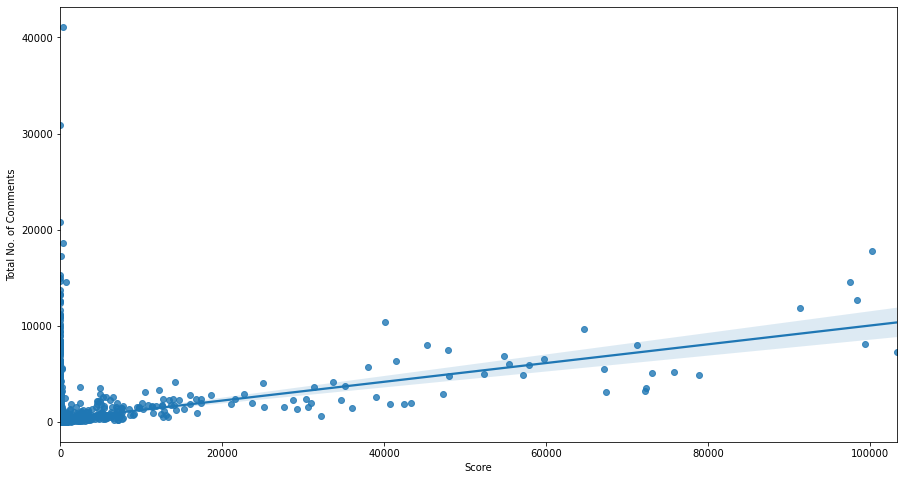

In [4]:
# Check relationship between Score and # Comments
plt.figure(figsize=(15,8))
sns.regplot(x=data.Score, y=data['Total No. of Comments'])

plt.show()

There are clear outliers in both directions, and a pretty weak positive relationship. Engagement doesn't seem to be useful in aggregate, but is good to set the cutoff for our data set. 

# Headline Information

# Words

In [5]:
# Create column of word lists and word counts
# Correct case of column and eliminate special characters

data['title_case_correct'] = data['Title'].str.lower()
data['title_case_correct'] = data['title_case_correct'].astype(str).replace('[^a-zA-Z0-9 ]','',regex=True)
data['title_words'] = data['title_case_correct'].str.split()

In [6]:
# One more col minus stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['title_words'] = data['title_words'].apply(lambda x: [item for item in x if item not in stop])

In [7]:
# Drop rows that are in other languages
data['language'] = data['title_case_correct'].apply(detect)
data = data[data['language'] == 'en']

In [8]:
# Lemmatize title and words

nlp = spacy.load('en_core_web_sm')

In [9]:
data['lemmatized'] = data['title_case_correct']

In [10]:
data['lemmatized'] = data['lemmatized'].apply(lambda row: " ".join(w.lemma_ for w in nlp(row)))

In [11]:
data['lemmatized_words'] = data['lemmatized'].str.split()

In [12]:
data['lemmatized_words'] = data['lemmatized_words'].apply(lambda x: [item for item in x if item not in stop])

In [13]:
# Add Percentile to the headlines

data['score_percentile'] = data.Score.rank(pct=True)
data['comments_percentile'] = data['Total No. of Comments'].rank(pct=True)


In [14]:
# Convert percentiles to bands (Top 10, Middle 40, Bottom 50)
bands = [(data['score_percentile'] >= .95), (data['score_percentile'] < .95) & (data['score_percentile'] > .5), (data['score_percentile'] <= .5)]
values = ['Top 5', 'Middle 45', 'Bottom 50']
data['score_band'] = np.select(bands, values)

In [15]:
# Convert percentiles to bands (Top 10, Middle 40, Bottom 50) for comments now
bands = [(data['comments_percentile'] >= .95), (data['comments_percentile'] < .95) & (data['comments_percentile'] > .5), (data['comments_percentile'] <= .5)]
values = ['Top 5', 'Middle 45', 'Bottom 50']
data['comm_band'] = np.select(bands, values)

In [16]:
# Make data sets for each band
data_score_5 = data[data['score_band'] == 'Top 5']
data_score_45 = data[data['score_band'] == 'Middle 45']
data_score_50 = data[data['score_band'] == 'Bottom 50']
data_comm_5 = data[data['comm_band'] == 'Top 5']
data_comm_45 = data[data['comm_band'] == 'Middle 45']
data_comm_50 = data[data['comm_band'] == 'Bottom 50']

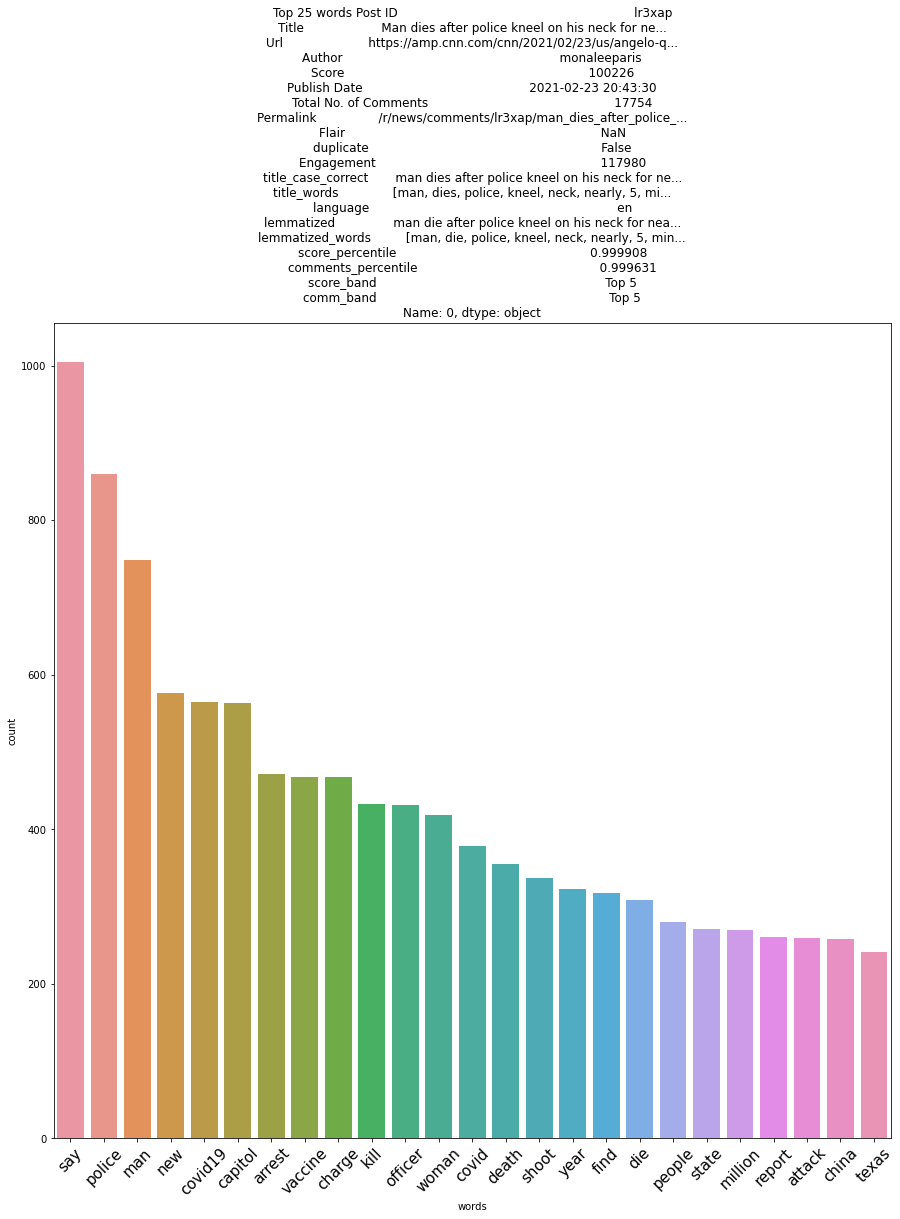

In [17]:
# Count and plot of most frequent words

words = data['lemmatized_words'].explode()
words_df = pd.DataFrame(words.value_counts())
words_df = words_df.reset_index()
words_df.columns = ['words','count']
top_25_words = words_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_words['words'], y=top_25_words['count'])
plt.title("Top 25 words " + str(df_name))
plt.xticks(rotation=45, size=15)

plt.show()

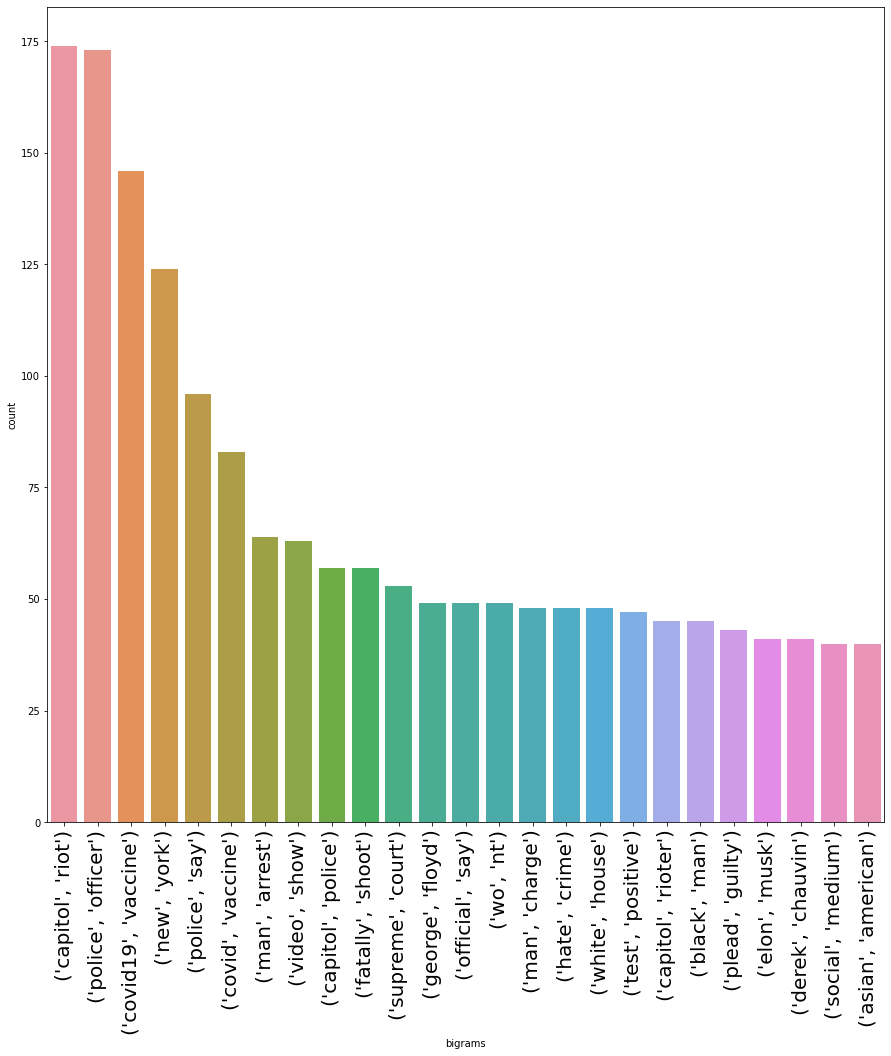

In [18]:
bigrams = pd.Series(nltk.ngrams(words,2)).value_counts()
bigrams_df = pd.DataFrame(bigrams)
bigrams_df = bigrams_df.reset_index()
bigrams_df.columns = ['bigrams','count']
top_25_bigrams = bigrams_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_bigrams['bigrams'], y=top_25_bigrams['count'])
plt.xticks(rotation=90, size=20)
plt.show()

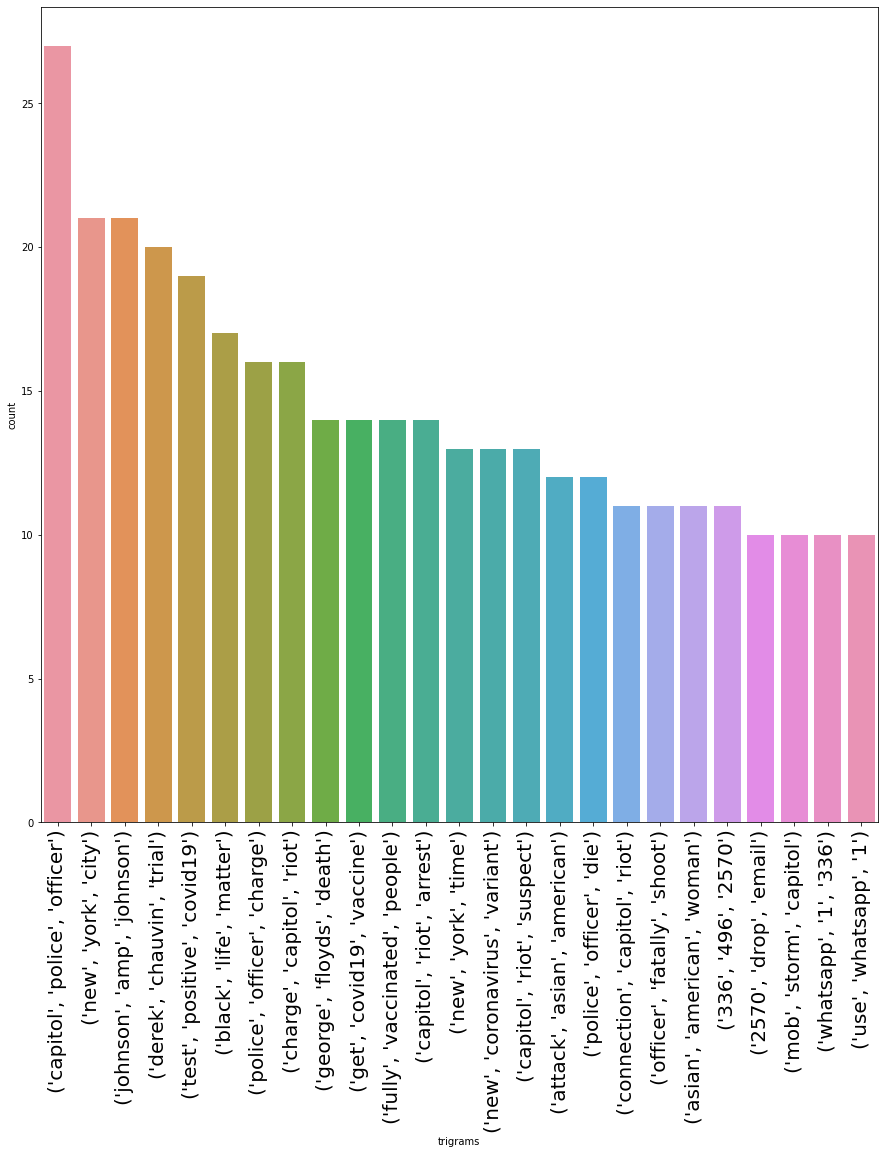

In [19]:
trigrams = pd.Series(nltk.ngrams(words,3)).value_counts()
trigrams_df = pd.DataFrame(trigrams)
trigrams_df = trigrams_df.reset_index()
trigrams_df.columns = ['trigrams','count']
top_25_trigrams = trigrams_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_trigrams['trigrams'], y=top_25_trigrams['count'])
plt.xticks(rotation=90, size=20)
plt.show()

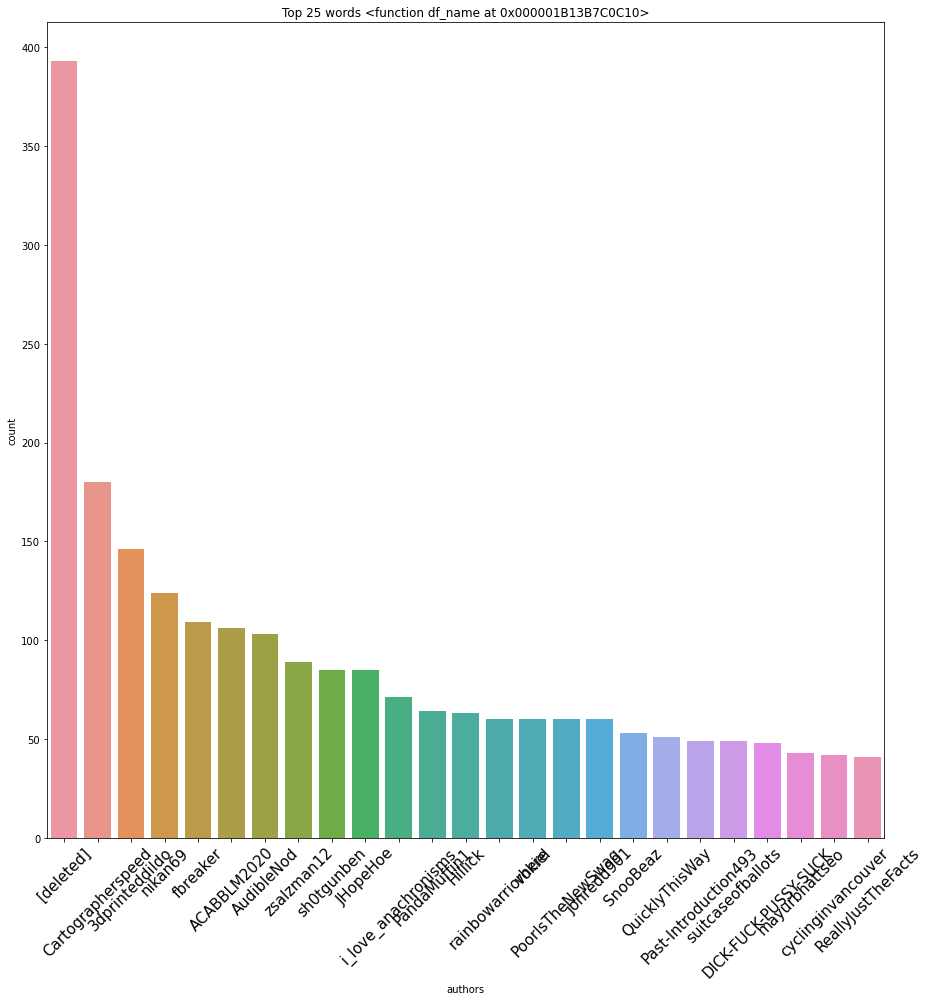

In [36]:

authors_df = pd.DataFrame(data['Author'].value_counts())
authors_df = authors_df.reset_index()
authors_df.columns = ['authors','count']
top_25_authors = authors_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_authors['authors'], y=top_25_authors['count'])
plt.title("Top 25 words " + str(df_name))
plt.xticks(rotation=45, size=15)

plt.show()

<AxesSubplot:xlabel='score_band', ylabel='Score'>

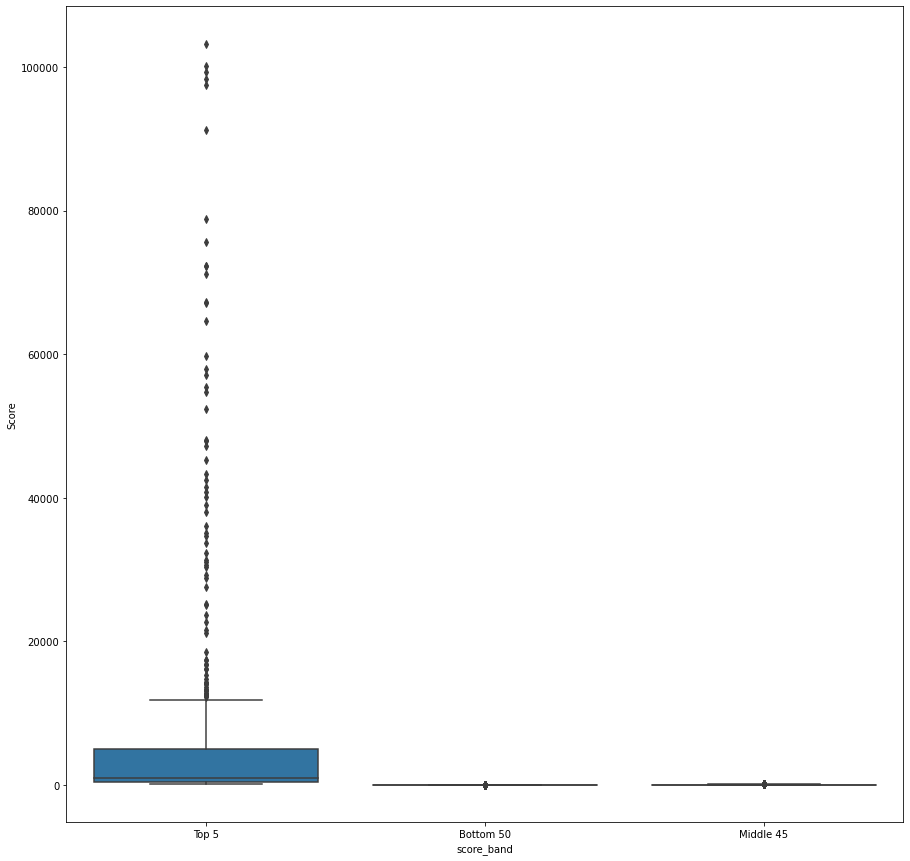

In [20]:
plt.figure(figsize=(15,15))
sns.boxplot(data=data['Score'], x=data['score_band'], y=data['Score'])

<AxesSubplot:xlabel='comm_band', ylabel='Total No. of Comments'>

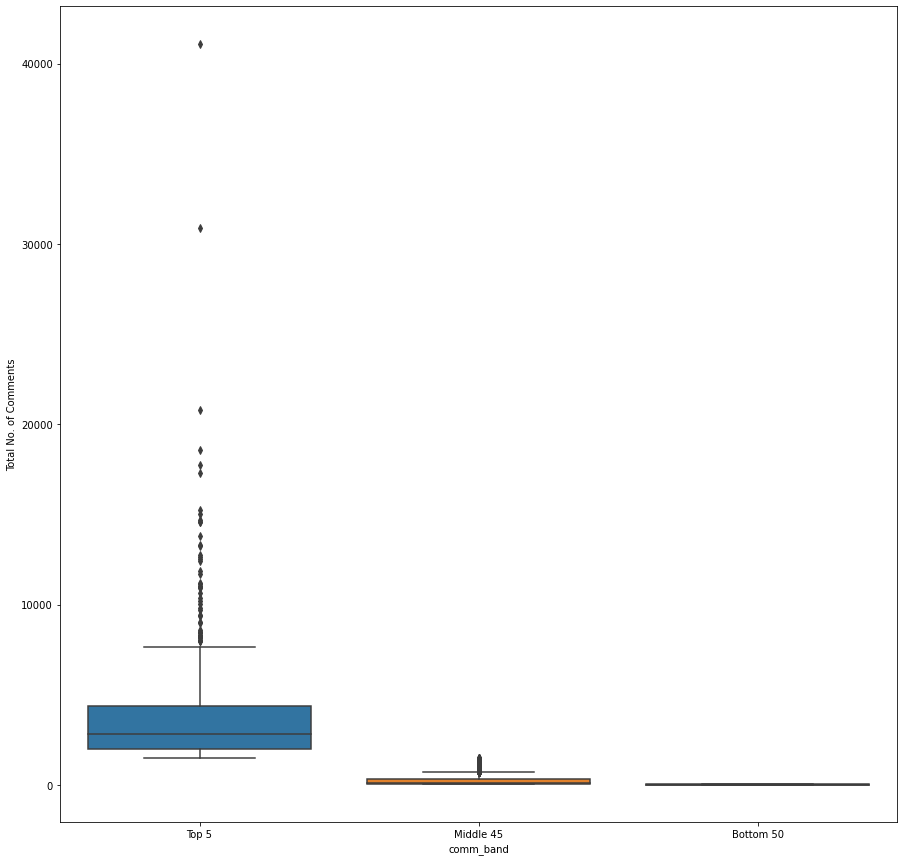

In [21]:
plt.figure(figsize=(15,15))
sns.boxplot(data=data['Total No. of Comments'], x=data['comm_band'], y=data['Total No. of Comments'])

In [22]:
# Colossal gap beteen top story's score and bottom story's, even within the band
# Consider a 1%/49%/50% split

data[data['score_band']=='Top 5'].describe()

,Score,Total No. of Comments,Engagement,score_percentile,comments_percentile
count,542.000000,542.000000,542.000000,542.000000,542.000000
mean,6879.588561,1056.450185,7936.038745,0.975035,0.780330
std,15951.173340,2684.808807,17621.388062,0.014454,0.185687
min,179.000000,6.000000,191.000000,0.950069,0.053392
25%,336.250000,102.500000,507.250000,0.962529,0.690102
50%,932.000000,297.500000,1372.000000,0.975035,0.830249
75%,4937.750000,860.500000,6046.750000,0.987517,0.922277
max,103302.000000,41107.000000,117980.000000,1.000000,1.000000


In [23]:
# Not a dramatic of a gap, but still very high

data[data['comm_band']=='Top 5'].describe()

,Score,Total No. of Comments,Engagement,score_percentile,comments_percentile
count,542.000000,542.000000,542.000000,542.000000,542.000000
mean,5234.210332,3882.918819,9117.129151,0.554070,0.975035
std,16131.081242,3459.657704,17109.842731,0.280982,0.014454
min,1.000000,1486.000000,1487.000000,0.332210,0.950069
25%,1.000000,1988.750000,2169.250000,0.332210,0.962552
50%,1.000000,2810.500000,3359.000000,0.332210,0.975035
75%,29.500000,4367.750000,6818.750000,0.875404,0.987517
max,103302.000000,41107.000000,117980.000000,1.000000,1.000000


In [24]:
def df_name(df):
    name = [x for x in globals() if globals()[x] is df][0]
    return name

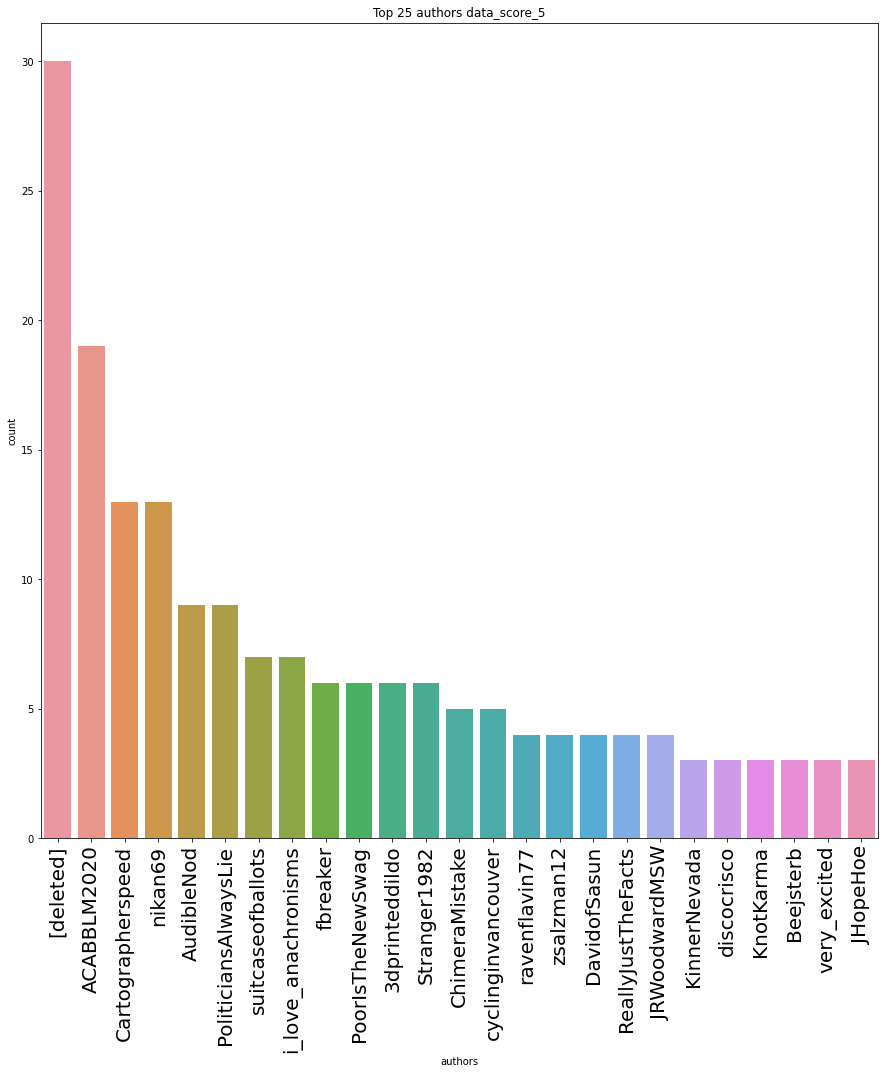

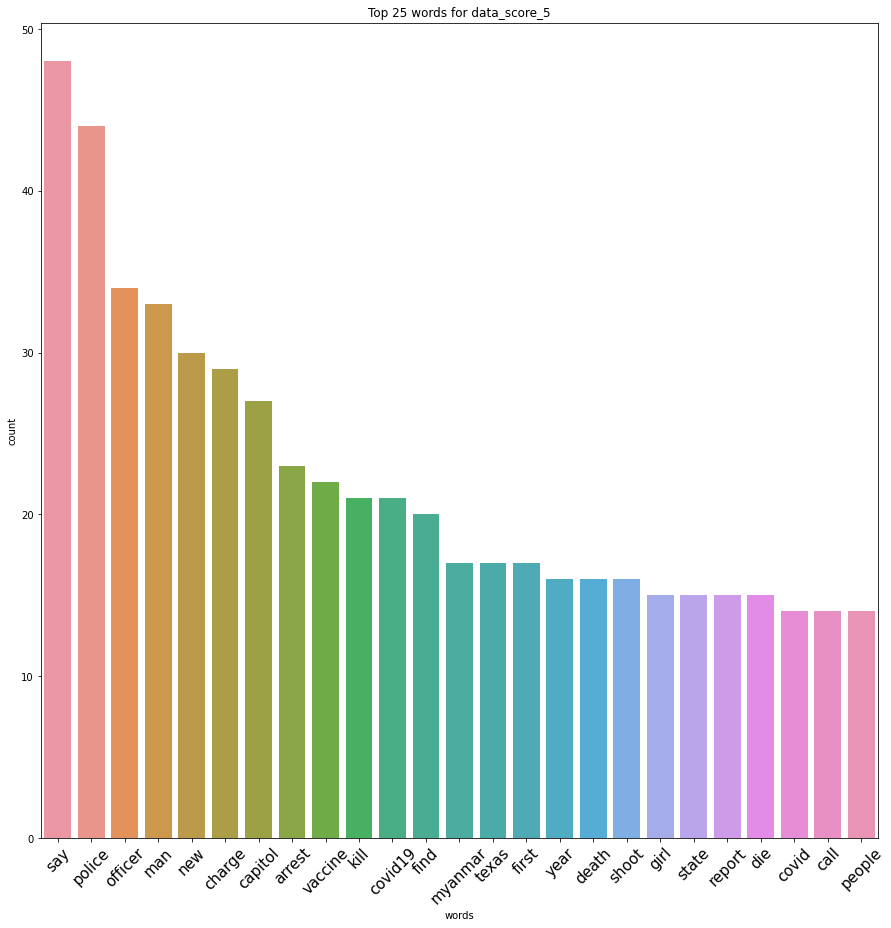

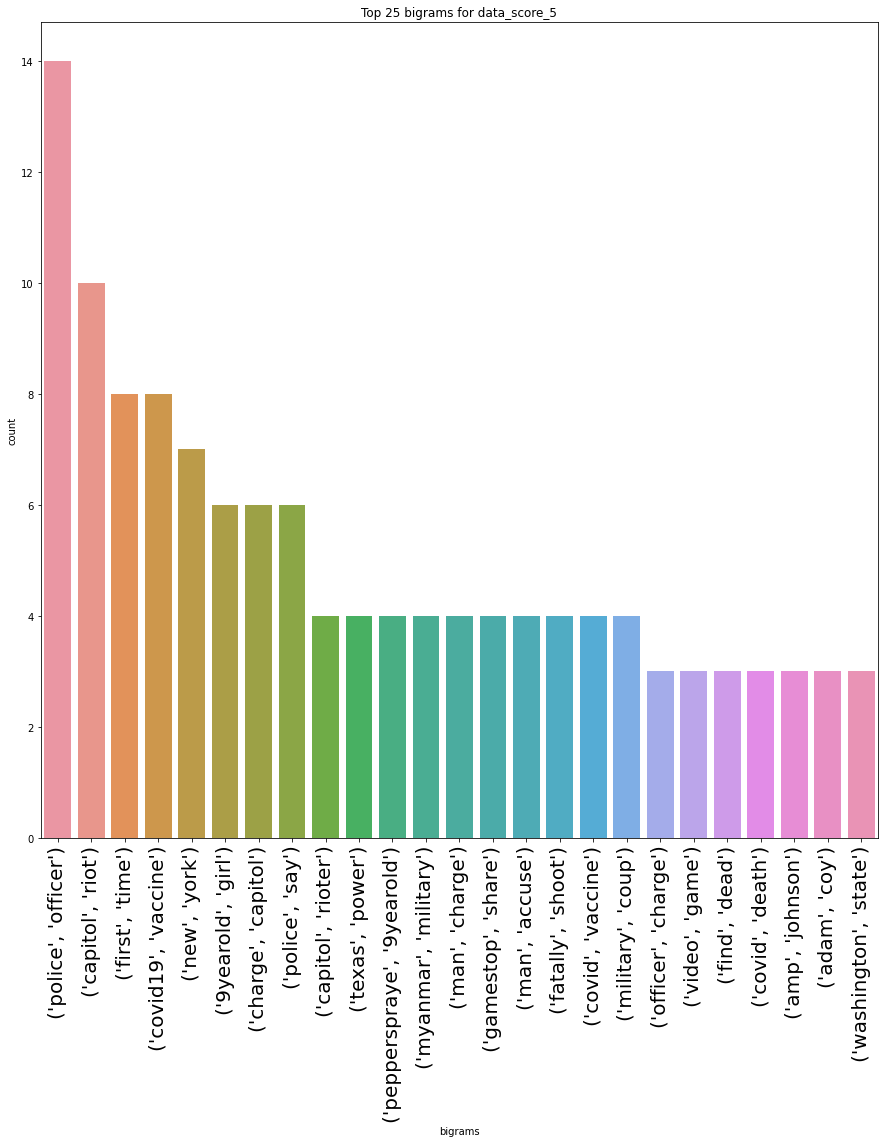

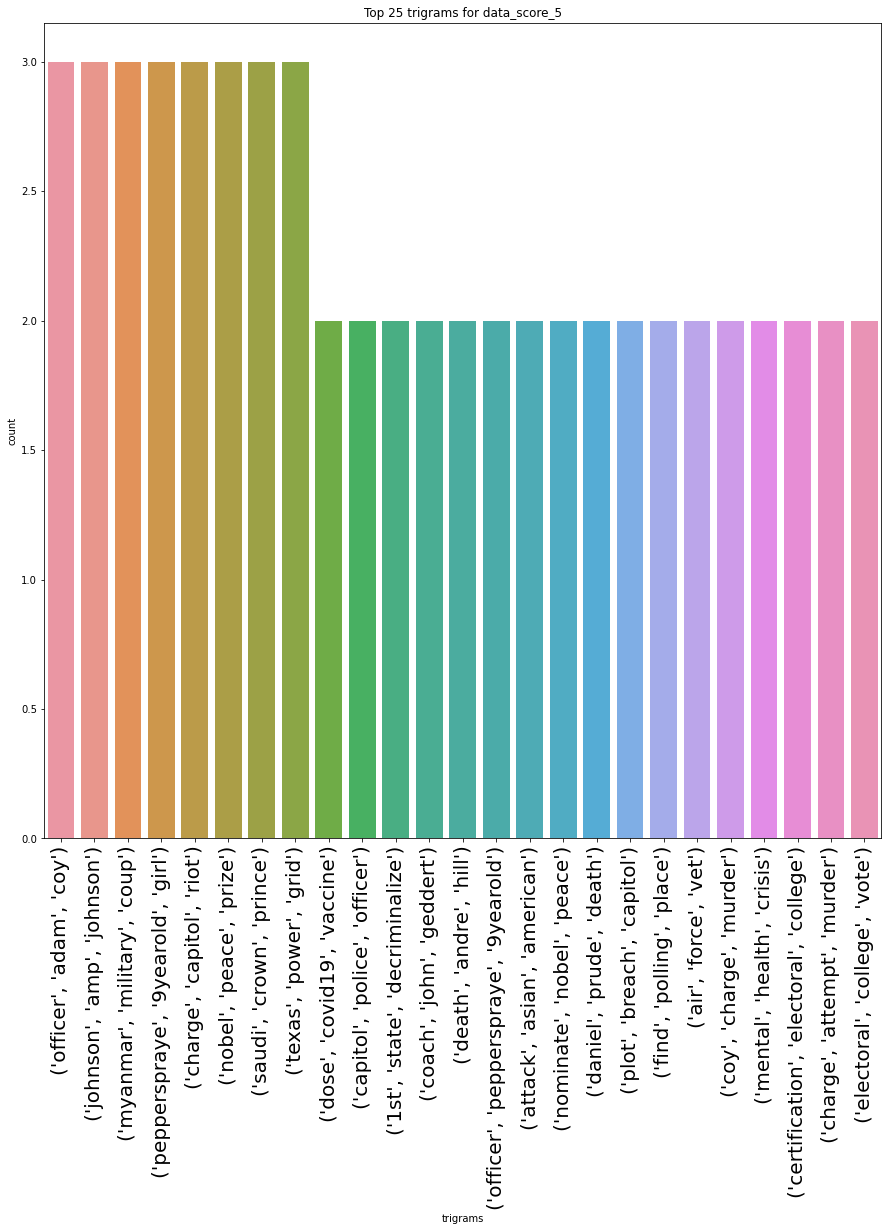

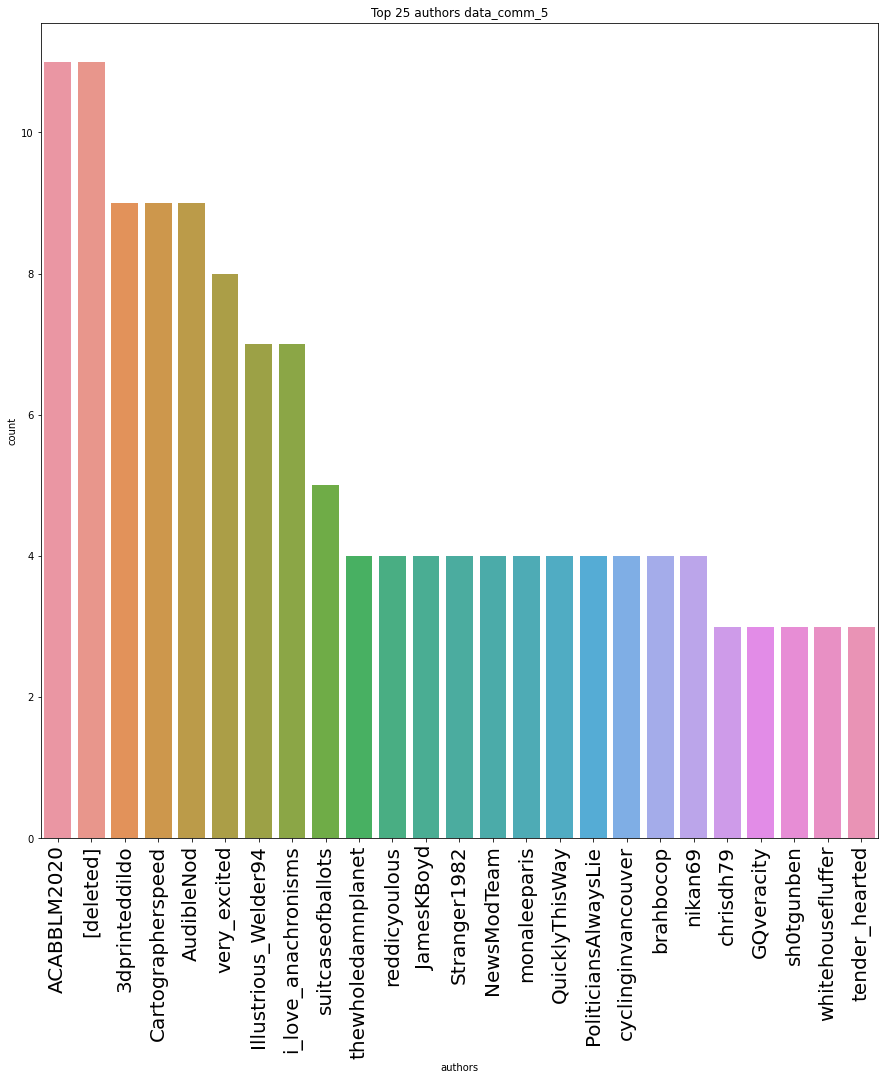

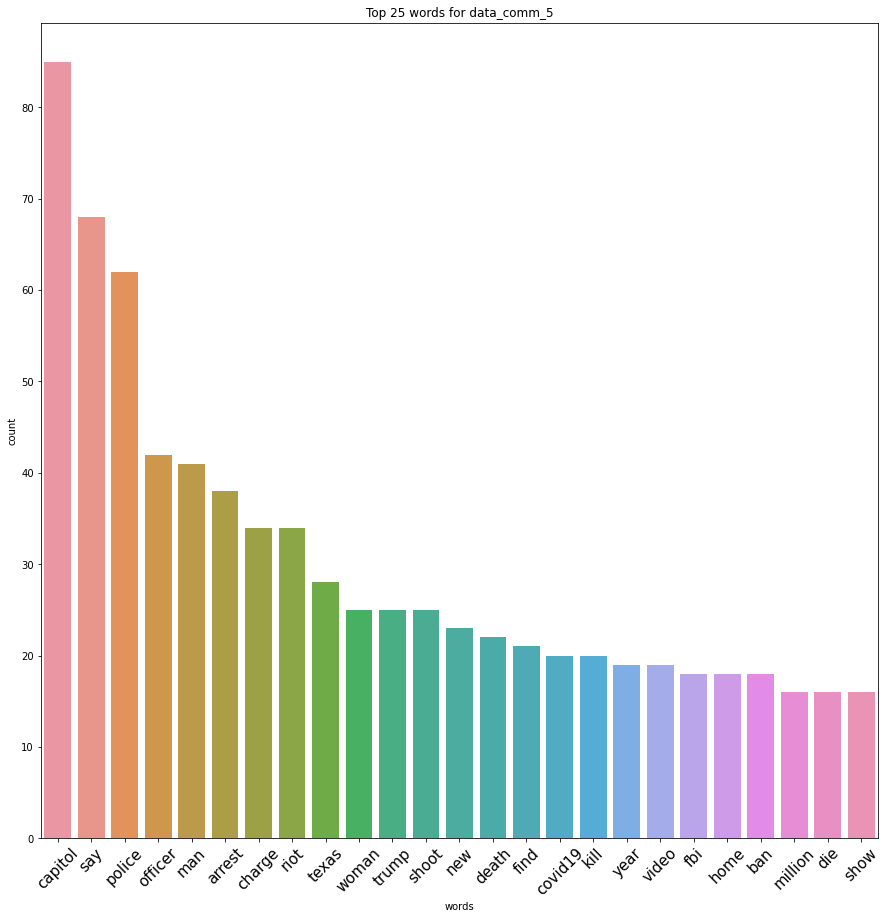

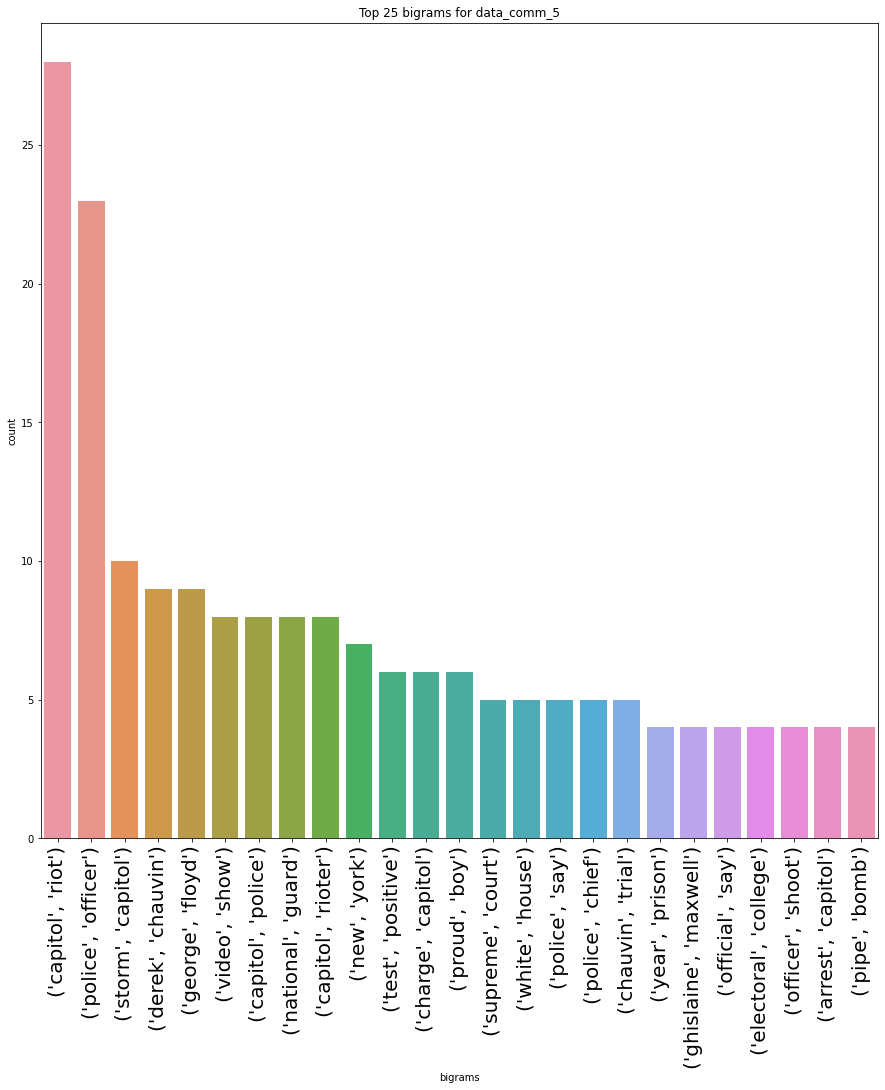

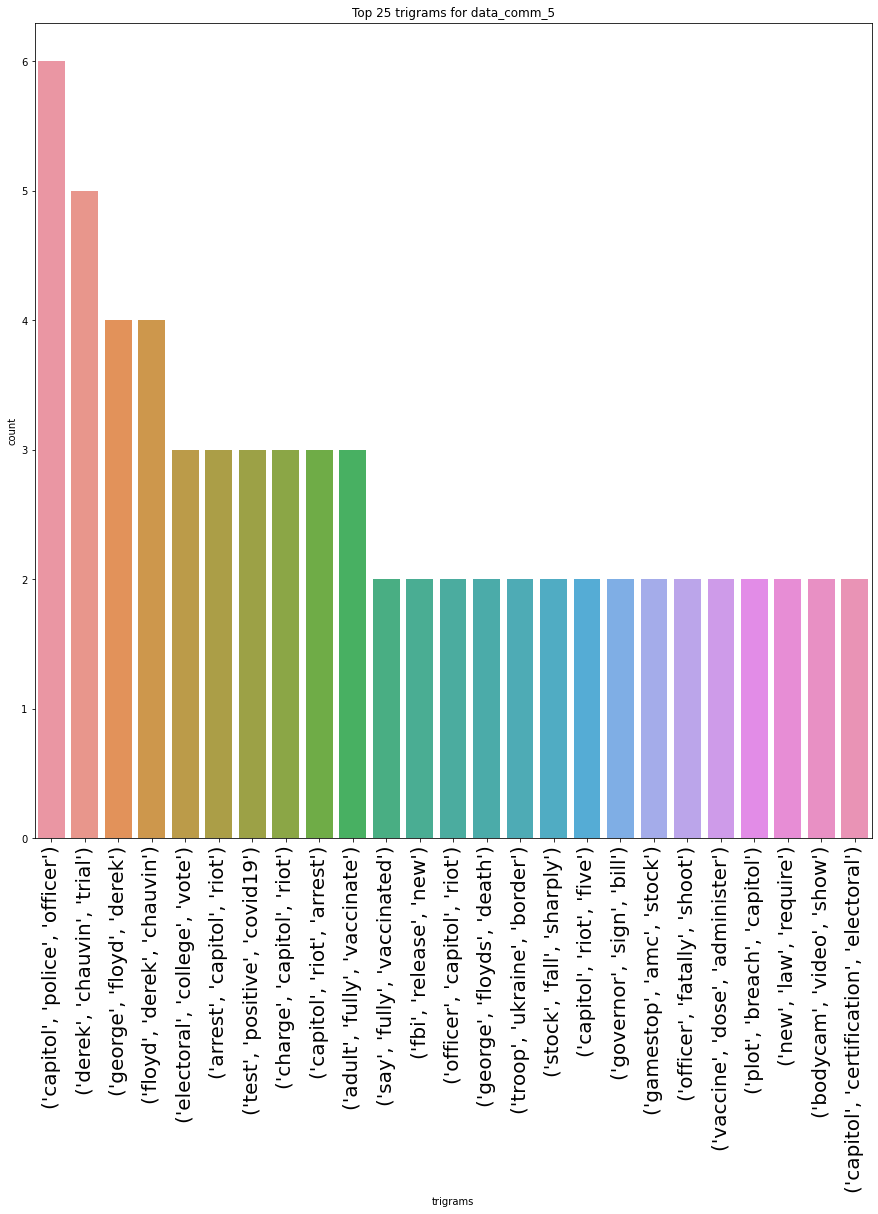

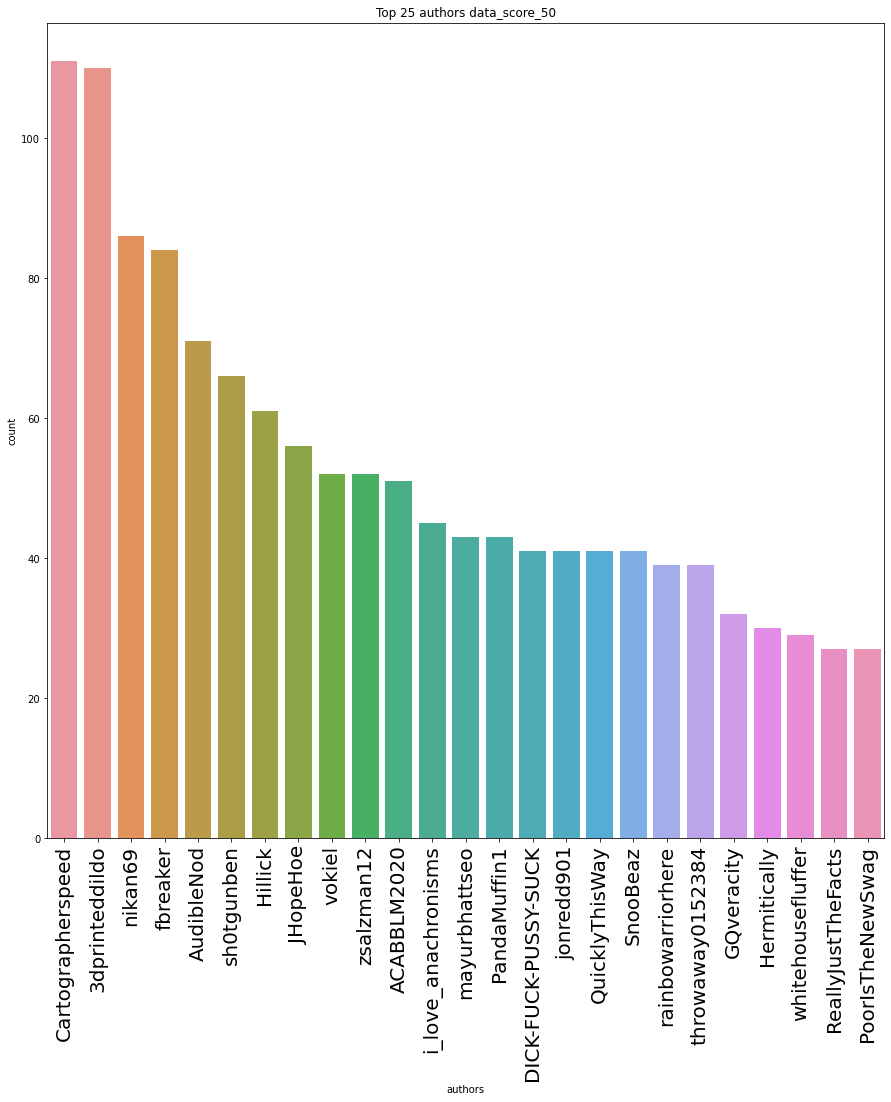

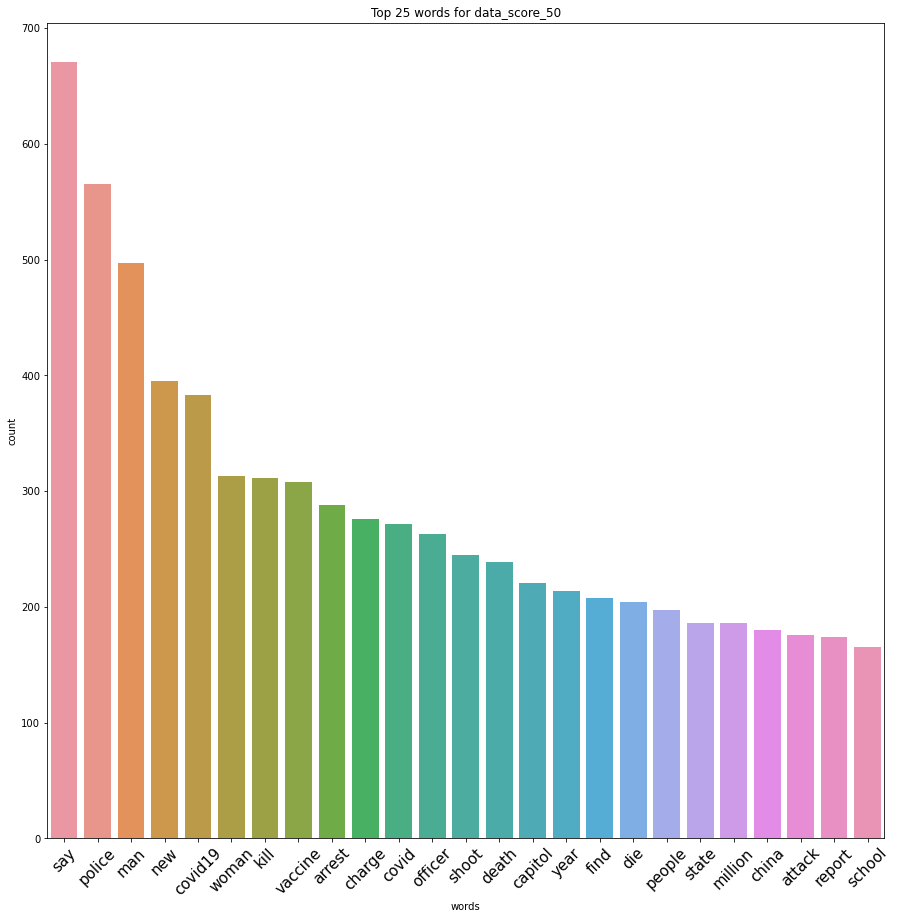

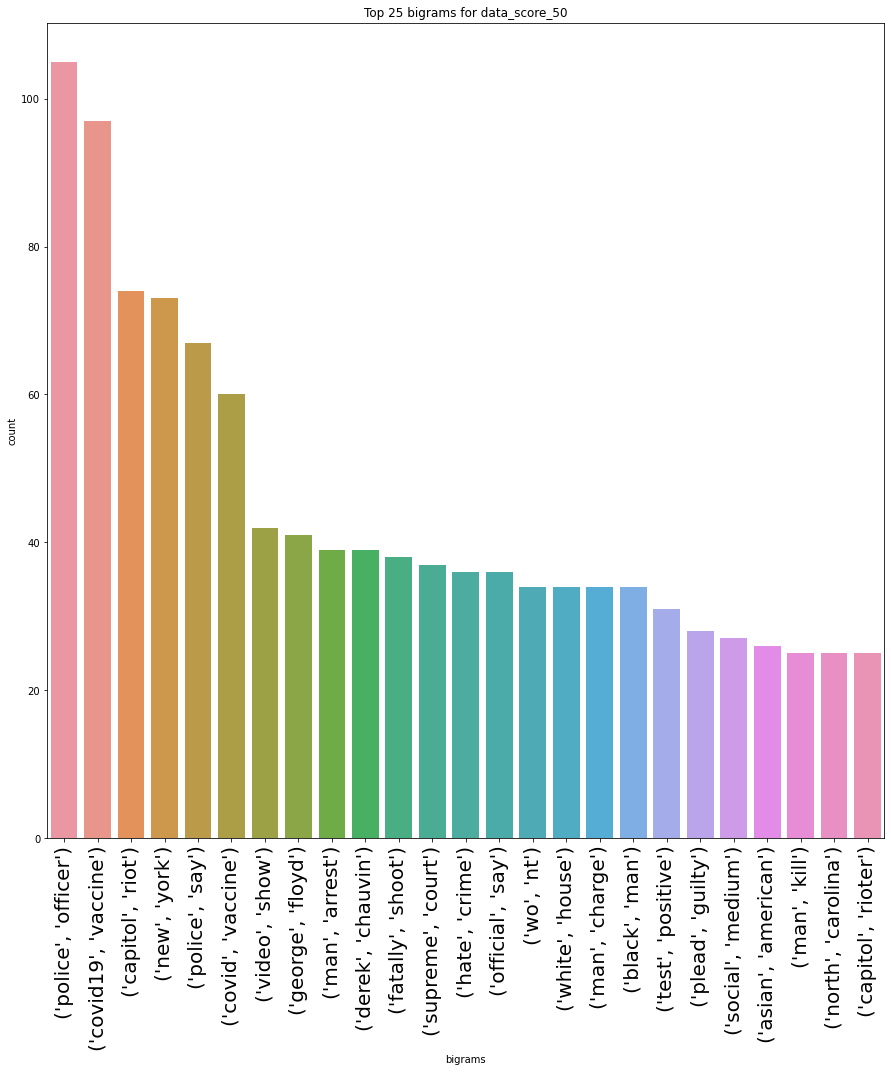

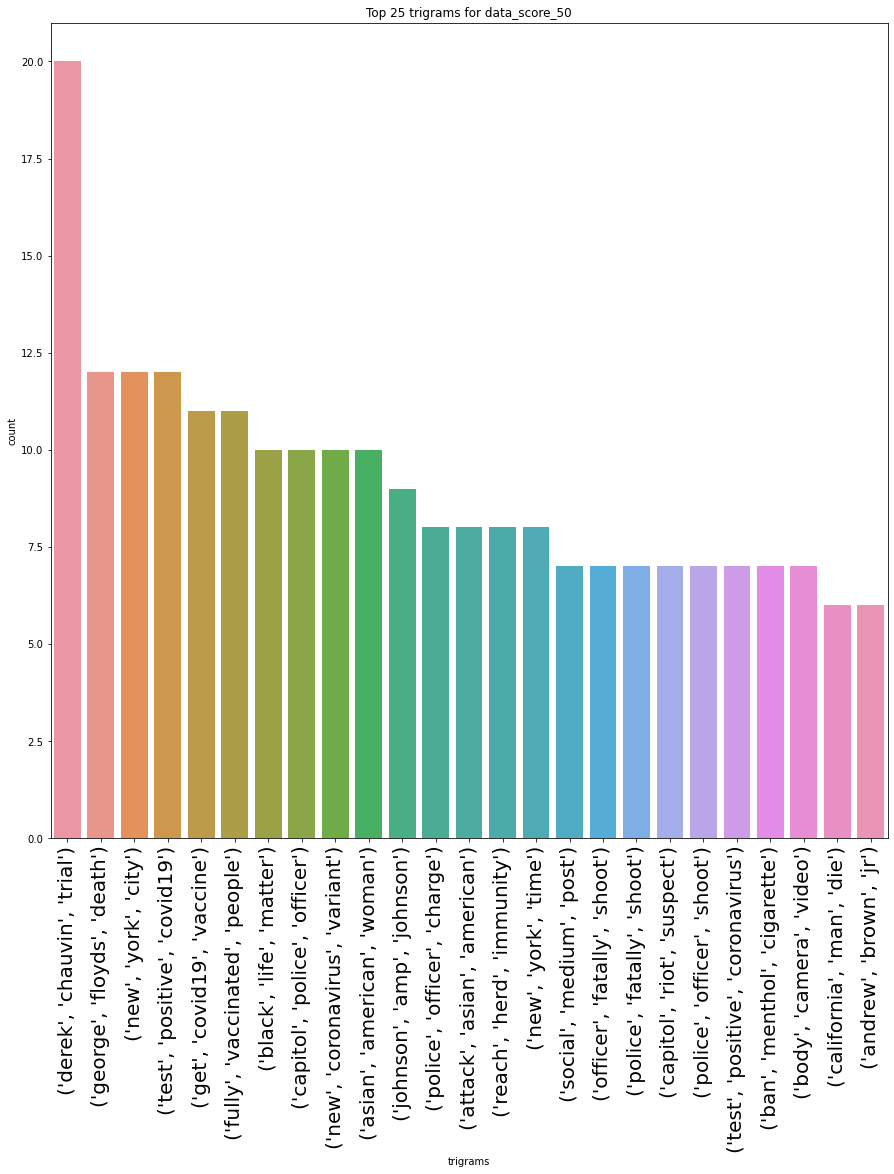

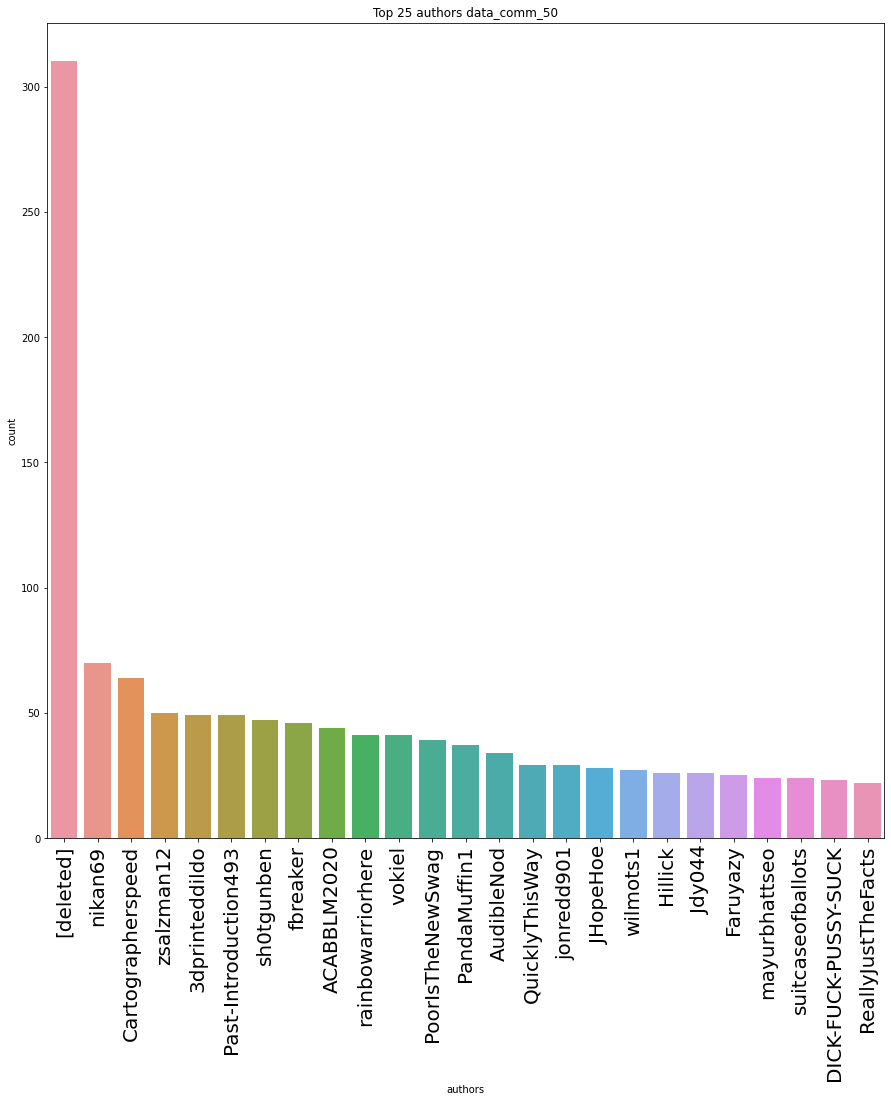

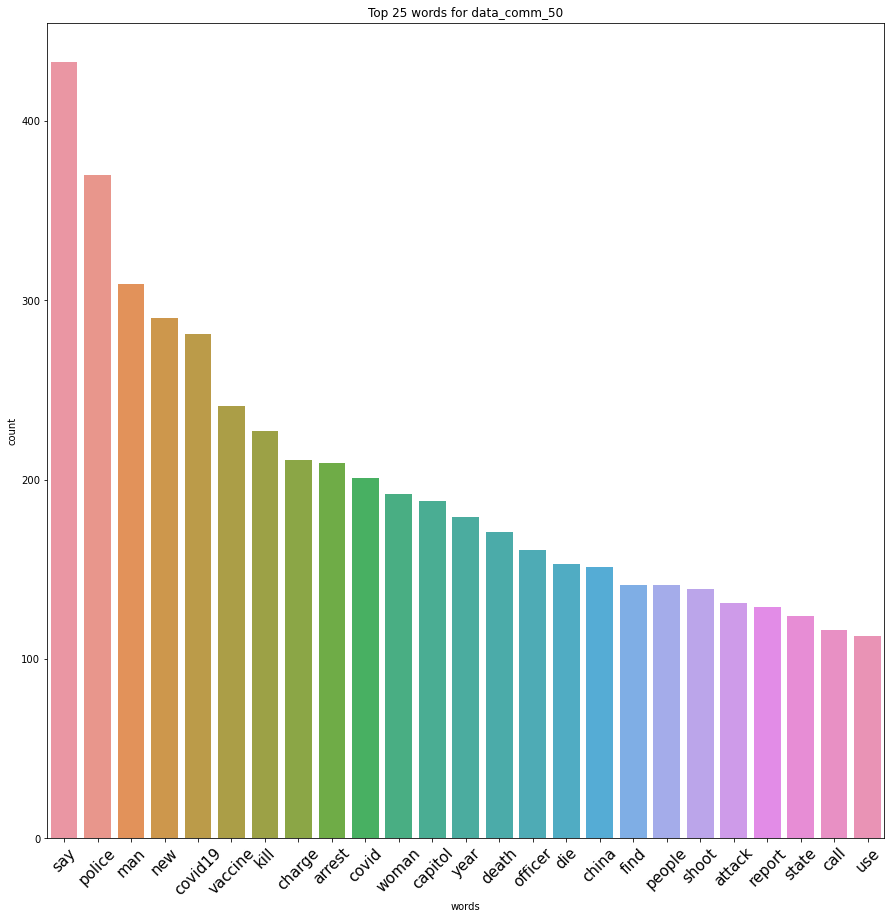

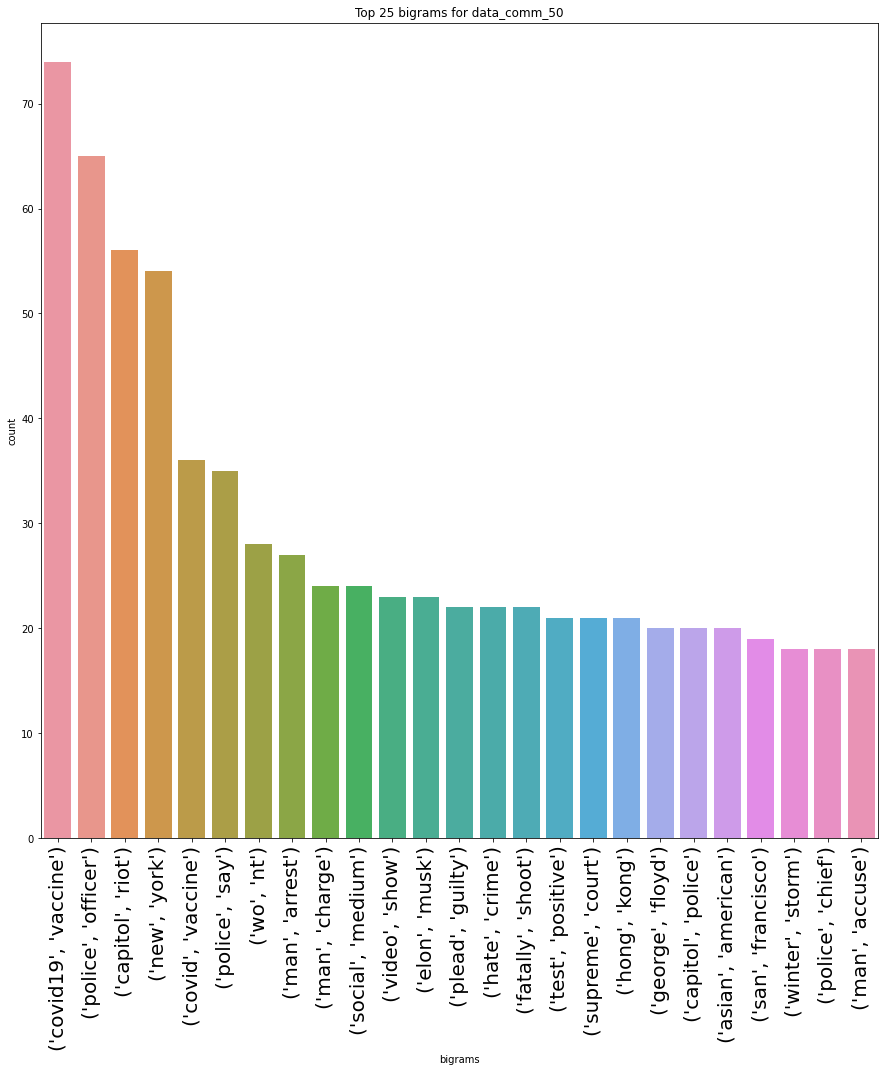

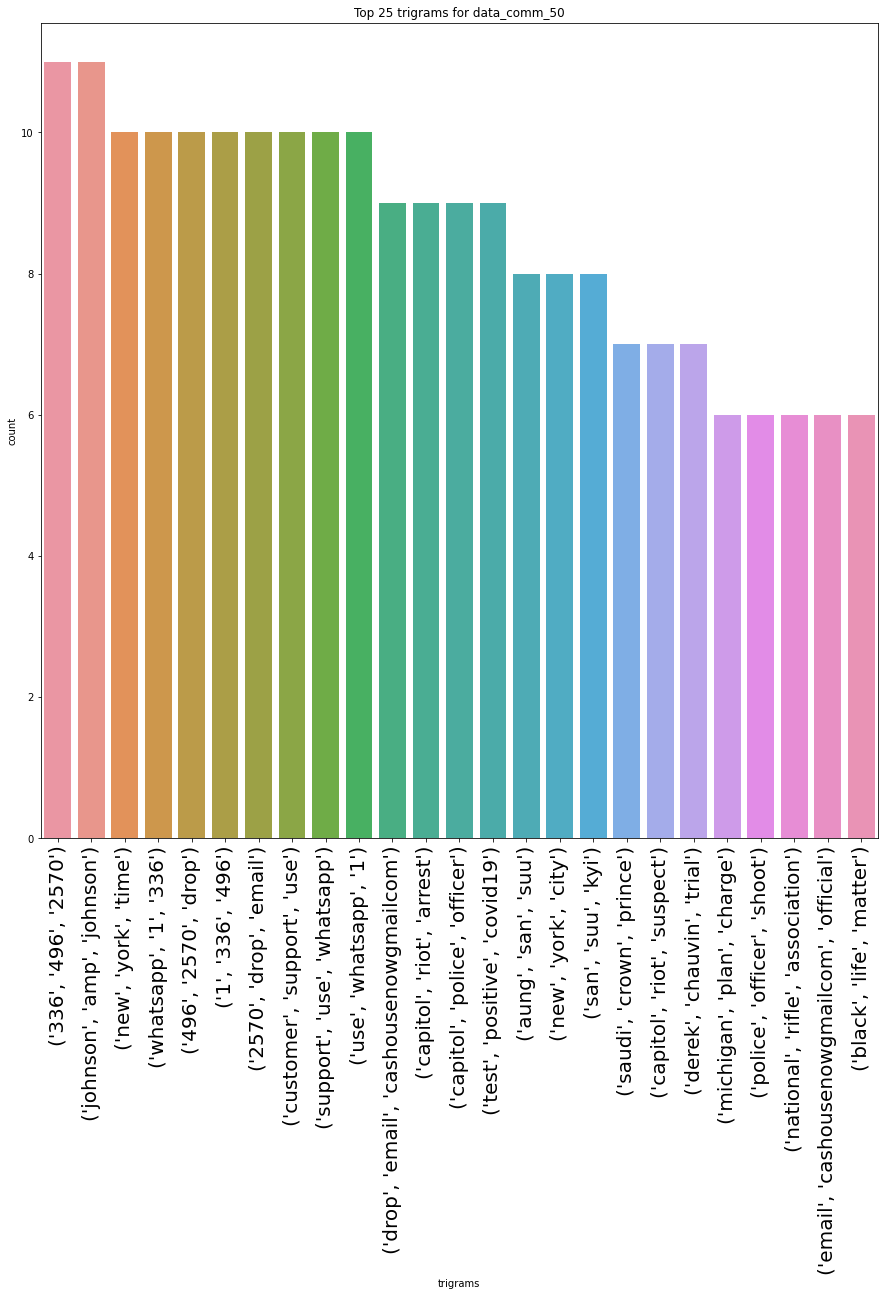

In [41]:
dfs = [data_score_5, data_comm_5, data_score_50, data_comm_50]

for df in dfs:
    name = df_name(df)
    


    authors_df = pd.DataFrame(df['Author'].value_counts())
    authors_df = authors_df.reset_index()
    authors_df.columns = ['authors','count']
    top_25_authors = authors_df.head(25)

    plt.figure(figsize=(15,15))
    sns.barplot(x=top_25_authors['authors'], y=top_25_authors['count'])
    plt.title("Top 25 authors " + str(name))
    plt.xticks(rotation=90, size=20)

    plt.show() 

    words = df['lemmatized_words'].explode()
    words_df = pd.DataFrame(words.value_counts())
    words_df = words_df.reset_index()
    words_df.columns = ['words','count']
    top_25_words = words_df.head(25)

    plt.figure(figsize=(15,15))
    sns.barplot(x=top_25_words['words'], y=top_25_words['count'])
    plt.title("Top 25 words for " + str(name))
    plt.xticks(rotation=45, size=15)
    plt.show()

    bigrams = pd.Series(nltk.ngrams(words,2)).value_counts()
    bigrams_df = pd.DataFrame(bigrams)
    bigrams_df = bigrams_df.reset_index()
    bigrams_df.columns = ['bigrams','count']
    top_25_bigrams = bigrams_df.head(25)

    plt.figure(figsize=(15,15))
    sns.barplot(x=top_25_bigrams['bigrams'], y=top_25_bigrams['count'])
    plt.title("Top 25 bigrams for " + str(name))
    plt.xticks(rotation=90, size=20)
    plt.show()

    trigrams = pd.Series(nltk.ngrams(words,3)).value_counts()
    trigrams_df = pd.DataFrame(trigrams)
    trigrams_df = trigrams_df.reset_index()
    trigrams_df.columns = ['trigrams','count']
    top_25_trigrams = trigrams_df.head(25)

    plt.figure(figsize=(15,15))
    sns.barplot(x=top_25_trigrams['trigrams'], y=top_25_trigrams['count'])
    plt.title("Top 25 trigrams for " + str(name))
    plt.xticks(rotation=90, size=20)
    plt.show()

In [42]:
data

,Post ID,Title,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,duplicate,Engagement,title_case_correct,title_words,language,lemmatized,lemmatized_words,score_percentile,comments_percentile,score_band,comm_band
0,lr3xap,Man dies after police kneel on his neck for ne...,https://amp.cnn.com/cnn/2021/02/23/us/angelo-q...,monaleeparis,100226,2021-02-23 20:43:30,17754,/r/news/comments/lr3xap/man_dies_after_police_...,NaN,False,117980,man dies after police kneel on his neck for ne...,"[man, dies, police, kneel, neck, nearly, 5, mi...",en,man die after police kneel on his neck for nea...,"[man, die, police, kneel, neck, nearly, 5, min...",0.999908,0.999631,Top 5,Top 5
1,lsmh36,Texan files $1 billion class-action lawsuit af...,https://abcnews.go.com/US/texan-files-billion-...,ACABBLM2020,97551,2021-02-25 17:30:11,14574,/r/news/comments/lsmh36/texan_files_1_billion_...,NaN,False,112125,texan files 1 billion classaction lawsuit afte...,"[texan, files, 1, billion, classaction, lawsui...",en,texan file 1 billion classaction lawsuit after...,"[texan, file, 1, billion, classaction, lawsuit...",0.999631,0.999169,Top 5,Top 5
2,ls7xmj,Trump tax returns are now in the hands of the ...,https://www.cnbc.com/2021/02/25/trump-tax-retu...,[deleted],98318,2021-02-25 06:38:18,12719,/r/news/comments/ls7xmj/trump_tax_returns_are_...,NaN,True,111037,trump tax returns are now in the hands of the ...,"[trump, tax, returns, hands, manhattan, distri...",en,trump tax return be now in the hand of the man...,"[trump, tax, return, hand, manhattan, district...",0.999723,0.998708,Top 5,Top 5
3,laun1r,Minneapolis police officers must keep body cam...,https://www.cnn.com/2021/02/02/us/minneapolis-...,dlkapt3,103302,2021-02-02 04:42:35,7312,/r/news/comments/laun1r/minneapolis_police_off...,NaN,False,110614,minneapolis police officers must keep body cam...,"[minneapolis, police, officers, must, keep, bo...",en,minneapolis police officer must keep body came...,"[minneapolis, police, officer, must, keep, bod...",1.000000,0.994832,Top 5,Top 5
4,lsbgop,Costco lifts minimum wage above Amazon or Targ...,https://www.reuters.com/article/us-costco-whol...,candordirect,99299,2021-02-25 09:11:08,8124,/r/news/comments/lsbgop/costco_lifts_minimum_w...,NaN,False,107423,costco lifts minimum wage above amazon or targ...,"[costco, lifts, minimum, wage, amazon, target,...",en,costco lift minimum wage above amazon or targe...,"[costco, lift, minimum, wage, amazon, target, ...",0.999815,0.996031,Top 5,Top 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11235,mxf36e,Bones of Black children killed in police bombi...,https://www.theguardian.com/us-news/2021/apr/2...,mod_89,1,2021-04-24 00:35:28,9,/r/news/comments/mxf36e/bones_of_black_childre...,NaN,False,10,bones of black children killed in police bombi...,"[bones, black, children, killed, police, bombi...",en,bone of black child kill in police bombing use...,"[bone, black, child, kill, police, bombing, us...",0.332210,0.091601,Bottom 50,Bottom 50
11236,mjb8qw,A juvenile has been arrested following a video...,https://www.cnn.com/2021/04/03/us/asian-couple...,Piranha_ChuckNorris,5,2021-04-03 08:57:30,5,/r/news/comments/mjb8qw/a_juvenile_has_been_ar...,NaN,False,10,a juvenile has been arrested following a video...,"[juvenile, arrested, following, videotaped, at...",en,a juvenile have be arrest follow a videotape a...,"[juvenile, arrest, follow, videotape, attack, ...",0.732257,0.045593,Middle 45,Bottom 50
11237,n3oquf,(Australia) 80yo fisher finds himself trapped ...,https://www.abc.net.au/news/2021-05-03/fisherm...,LuckyBdx4,1,2021-05-02 22:29:06,9,/r/news/comments/n3oquf/australia_80yo_fisher_...,NaN,False,10,australia 80yo fisher finds himself trapped in...,"[australia, 80yo, fisher, finds, trapped, tinn...",en,australia 80yo fisher find himself trap in a t...,"[australia, 80yo, fisher, find, trap, tinny, t...",0.332210,0.091601,Bottom 50,Bottom 50
11238,n545c8,Minorities underrepre

In [ ]:
data['story_label']